# Strong Lensing Image Super-Resolution

This notebook implements a deep learning-based super-resolution model to upscale low-resolution (LR) strong lensing images using provided high-resolution (HR) samples as ground truth. The model is implemented in PyTorch and evaluated using standard metrics (MSE, SSIM, PSNR).

## 1. Import Required Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 2. Dataset Preparation

We'll create a custom dataset class to load the high-resolution and low-resolution strong lensing images stored as NumPy arrays.

In [ ]:
class LensingDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, max_samples=None):
        
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        
        # Get the list of npy file names that exist in both directories
        hr_files = set(f for f in os.listdir(hr_dir) if f.endswith('.npy'))
        lr_files = set(f for f in os.listdir(lr_dir) if f.endswith('.npy'))
        all_files = sorted(list(hr_files.intersection(lr_files)))
        
        # Limit the number of samples if specified
        if max_samples and max_samples < len(all_files):
            self.image_files = all_files[:max_samples]
        else:
            self.image_files = all_files
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        hr_path = os.path.join(self.hr_dir, self.image_files[idx])
        lr_path = os.path.join(self.lr_dir, self.image_files[idx])
        
        # Load numpy arrays
        hr_image = np.load(hr_path)
        lr_image = np.load(lr_path)
        
        # Ensure arrays are 2D
        if hr_image.ndim > 2:
            hr_image = hr_image.squeeze()
        if lr_image.ndim > 2:
            lr_image = lr_image.squeeze()
  
        hr_tensor = torch.from_numpy(hr_image).float().unsqueeze(0)  
        lr_tensor = torch.from_numpy(lr_image).float().unsqueeze(0)  
        
        hr_tensor = hr_tensor * 2 - 1
        lr_tensor = lr_tensor * 2 - 1
        
        return lr_tensor, hr_tensor

In [ ]:
# Set paths to data directories
hr_dir = os.path.join(os.getcwd(), "HR")
lr_dir = os.path.join(os.getcwd(), "LR")

print(f"Found {len([f for f in os.listdir(hr_dir) if f.endswith('.npy')])} HR images and {len([f for f in os.listdir(lr_dir) if f.endswith('.npy')])} LR images")

max_samples = 500  # Limit to 500 samples for faster training
dataset = LensingDataset(hr_dir, lr_dir, max_samples=max_samples)
print(f"Using {len(dataset)} images for training and testing")

# Split into training and testing sets (80:20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

# Create data loaders with larger batch size for faster training
batch_size = 32  # Increase batch size for faster training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Found 10000 HR images and 10000 LR images
Using 500 images for training and testing
Training set size: 400
Testing set size: 100


### Visualize Sample Images

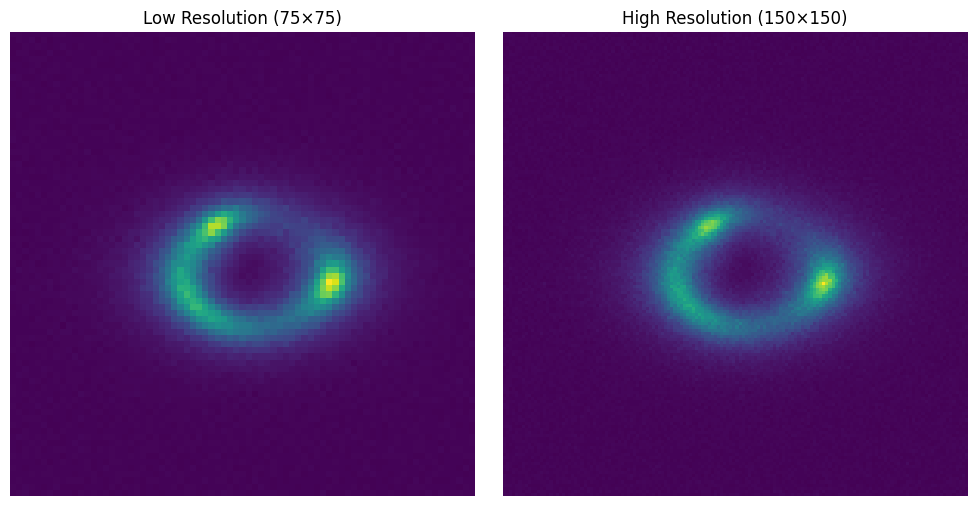

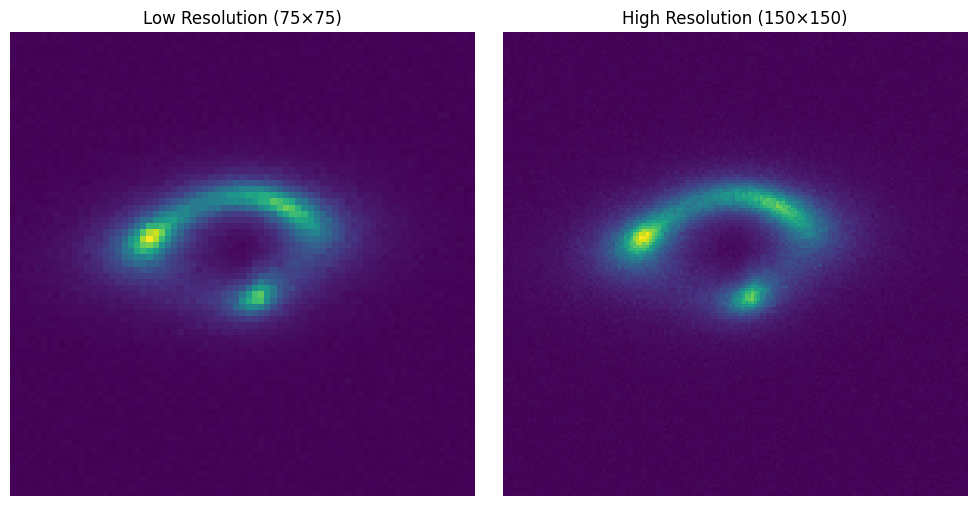

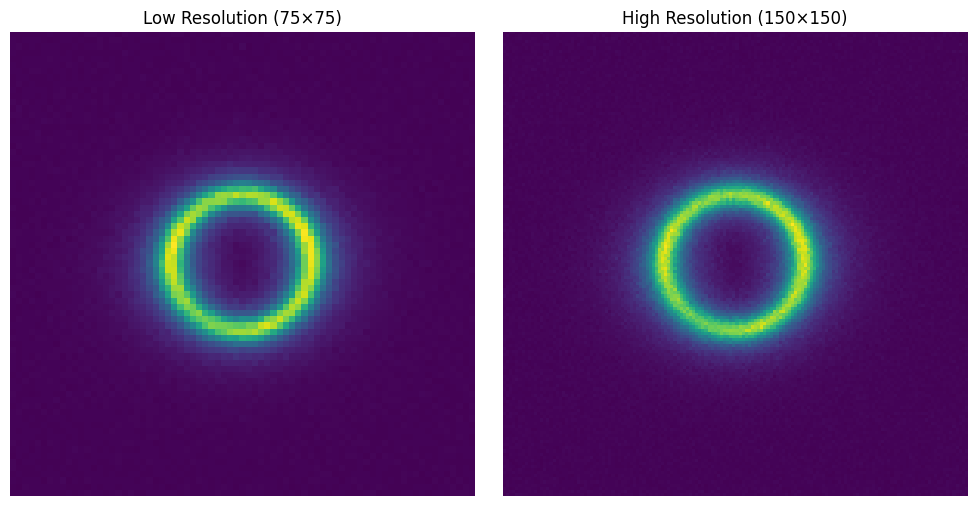

In [ ]:
def show_example(dataset, index=0):
    lr_img, hr_img = dataset[index]
    
    lr_img = lr_img.squeeze().numpy() * 0.5 + 0.5
    hr_img = hr_img.squeeze().numpy() * 0.5 + 0.5
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(lr_img, cmap='viridis')
    axes[0].set_title(f"Low Resolution ({lr_img.shape[0]}×{lr_img.shape[1]})")
    axes[0].axis('off')
    
    axes[1].imshow(hr_img, cmap='viridis')
    axes[1].set_title(f"High Resolution ({hr_img.shape[0]}×{hr_img.shape[1]})")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show a few examples
for _ in range(3):
    show_example(dataset, index=np.random.randint(0, len(dataset)))

## 3. Super-Resolution Model Architecture

We'll implement a residual-based super-resolution network with skip connections to enhance the details in low-resolution images.

In [4]:
class ResidualBlock(nn.Module):
    """Residual block with skip connection"""
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Skip connection
        out = self.relu(out)
        return out

class SuperResolutionModel(nn.Module):
    
    def __init__(self, in_channels=1, num_residual_blocks=8, upscale_factor=4):
        super(SuperResolutionModel, self).__init__()
        
      
        self.conv_input = nn.Conv2d(in_channels, 64, kernel_size=9, padding=4)
        self.relu = nn.ReLU(inplace=True)
        
      
        res_blocks = []
        for _ in range(num_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)
        
        # Second conv layer after residual blocks
        self.conv_mid = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn_mid = nn.BatchNorm2d(64)
        
        
        upsampling = []
        for _ in range(int(np.log2(upscale_factor))):
            upsampling.append(nn.Conv2d(64, 256, kernel_size=3, padding=1))
            upsampling.append(nn.PixelShuffle(2))  # Increases resolution by 2x
            upsampling.append(nn.ReLU(inplace=True))
        self.upsampling = nn.Sequential(*upsampling)
        
        # Final output layer
        self.conv_output = nn.Conv2d(64, in_channels, kernel_size=9, padding=4)
        self.sigmoid = nn.Tanh()  # Output range [-1, 1] to match input normalization
        
    def forward(self, x):
     
        if len(x.shape) < 4:  
            x = x.unsqueeze(0)  # Add batch dimension if missing
            
        # Initial feature extraction
        out1 = self.relu(self.conv_input(x))
        
        # Residual blocks
        out = self.res_blocks(out1)
        
        out2 = self.bn_mid(self.conv_mid(out))
        out = torch.add(out1, out2)
        
        # Upsampling
        out = self.upsampling(out)
        out = self.conv_output(out)
        out = self.sigmoid(out)  # Apply Tanh for [-1, 1] range
        
        return out

class LightweightSuperResolutionModel(nn.Module):
    """Simplified Super-resolution model with fewer parameters"""
    def __init__(self, in_channels=1, num_residual_blocks=4, upscale_factor=4):
        super(LightweightSuperResolutionModel, self).__init__()
        
        # First conv layer
        self.conv_input = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual blocks with fewer channels
        res_blocks = []
        for _ in range(num_residual_blocks):
            res_blocks.append(ResidualBlock(32))
        self.res_blocks = nn.Sequential(*res_blocks)
        
        # Second conv layer after residual blocks
        self.conv_mid = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn_mid = nn.BatchNorm2d(32)
        
        # Upsampling layers using pixel shuffle for efficient upscaling
        upsampling = []
        for _ in range(int(np.log2(upscale_factor))):
            upsampling.append(nn.Conv2d(32, 128, kernel_size=3, padding=1))
            upsampling.append(nn.PixelShuffle(2))  # Increases resolution by 2x
            upsampling.append(nn.ReLU(inplace=True))
        self.upsampling = nn.Sequential(*upsampling)
        
        # Final output layer
        self.conv_output = nn.Conv2d(32, in_channels, kernel_size=3, padding=1)
        self.sigmoid = nn.Tanh()  # Output range [-1, 1] to match input normalization
        
    def forward(self, x):
        # Check input dimensions
        if len(x.shape) < 4:  # If input has less than 4 dimensions (batch, channel, height, width)
            x = x.unsqueeze(0)  # Add batch dimension if missing
            
        # Initial feature extraction
        out1 = self.relu(self.conv_input(x))
        
        # Residual blocks
        out = self.res_blocks(out1)
        
        # Global skip connection
        out2 = self.bn_mid(self.conv_mid(out))
        out = torch.add(out1, out2)
        
        # Upsampling
        out = self.upsampling(out)
        out = self.conv_output(out)
        out = self.sigmoid(out)  # Apply Tanh for [-1, 1] range
        
        return out

In [8]:
# Determine upscale factor from a sample pair
lr_sample, hr_sample = dataset[0]
upscale_factor = hr_sample.shape[-1] // lr_sample.shape[-1]
print(f"Detected upscale factor: {upscale_factor}x")

model = LightweightSuperResolutionModel(in_channels=1, num_residual_blocks=4, upscale_factor=upscale_factor)
model = model.to(device)

print(model)
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters()):,}")

original_model = SuperResolutionModel(in_channels=1, num_residual_blocks=8, upscale_factor=upscale_factor)
original_params = sum(p.numel() for p in original_model.parameters())
lightweight_params = sum(p.numel() for p in model.parameters())
reduction = (1 - lightweight_params/original_params) * 100

print(f"\nParameter reduction: {reduction:.1f}% ({lightweight_params:,} vs {original_params:,})")
print(f"The lightweight model should train significantly faster")

Detected upscale factor: 2x
LightweightSuperResolutionModel(
  (conv_input): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runni

## 4. Training Setup

Define the loss function, optimizer, and evaluation metrics for training and validation.

In [9]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Evaluation metrics
def calculate_metrics(sr_img, hr_img):
   
    sr_img = sr_img.cpu().numpy()
    hr_img = hr_img.cpu().numpy()
    
    # Rescale from [-1, 1] to [0, 1]
    sr_img = sr_img * 0.5 + 0.5
    hr_img = hr_img * 0.5 + 0.5
    
    # Calculate metrics
    psnr_val = psnr(hr_img, sr_img, data_range=1.0)
    ssim_val = ssim(hr_img, sr_img, data_range=1.0)
    
    return psnr_val, ssim_val

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    
    model.train()
    running_loss = 0.0
    
    for lr_imgs, hr_imgs in tqdm(dataloader, desc="Training"):
     
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        
 
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(lr_imgs)
        
        # Calculate loss
        loss = criterion(outputs, hr_imgs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * lr_imgs.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    
    model.eval()
    running_loss = 0.0
    psnr_scores = []
    ssim_scores = []
    
    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(dataloader, desc="Validation"):
          
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            
          
            outputs = model(lr_imgs)
            
            # Calculate loss
            loss = criterion(outputs, hr_imgs)
            running_loss += loss.item() * lr_imgs.size(0)
            
          
            for i in range(lr_imgs.size(0)):
                psnr_val, ssim_val = calculate_metrics(outputs[i].squeeze(), hr_imgs[i].squeeze())
                psnr_scores.append(psnr_val)
                ssim_scores.append(ssim_val)
    

    avg_loss = running_loss / len(dataloader.dataset)
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    
    return avg_loss, avg_psnr, avg_ssim

def fast_validate(model, dataloader, criterion, device, max_samples=100):
    """Optimized validation function that limits the number of samples for faster evaluation"""
    model.eval()
    running_loss = 0.0
    psnr_scores = []
    ssim_scores = []
    sample_count = 0
    
    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(dataloader, desc="Validation"):
            # Limit samples processed
            if sample_count >= max_samples:
                break
                
            
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
         
            outputs = model(lr_imgs)
            
       
            loss = criterion(outputs, hr_imgs)
            
            batch_size = lr_imgs.size(0)
            running_loss += loss.item() * batch_size
            sample_count += batch_size
            
            for i in range(min(batch_size, max_samples - len(psnr_scores))):
                if len(psnr_scores) >= max_samples:
                    break
                psnr_val, ssim_val = calculate_metrics(outputs[i].squeeze(), hr_imgs[i].squeeze())
                psnr_scores.append(psnr_val)
                ssim_scores.append(ssim_val)
  
    avg_loss = running_loss / sample_count
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    
    return avg_loss, avg_psnr, avg_ssim

## 5. Training the Model

We'll train the super-resolution model for several epochs and track the loss and evaluation metrics.

In [12]:

num_epochs = 30  
best_val_loss = float('inf')
checkpoint_dir = os.path.join(os.getcwd(), "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

patience = 10
no_improve_counter = 0
early_stop = False

train_losses = []
val_losses = []
val_psnrs = []
val_ssims = []

# Training loop with early stopping
for epoch in range(num_epochs):
    if early_stop:
        print(f"Early stopping at epoch {epoch}")
        break
        
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate with fast validation (limited samples)
    val_loss, val_psnr, val_ssim = fast_validate(model, test_loader, criterion, device, max_samples=100)
    val_losses.append(val_loss)
    val_psnrs.append(val_psnr)
    val_ssims.append(val_ssim)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.6f} | "
          f"Val Loss: {val_loss:.6f} | "
          f"PSNR: {val_psnr:.2f} dB | "
          f"SSIM: {val_ssim:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_psnr': val_psnr,
            'val_ssim': val_ssim
        }, checkpoint_path)
        print(f"Saved best model checkpoint")
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print(f"No improvement for {patience} epochs. Early stopping.")
            early_stop = True

Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 0.000724 | Val Loss: 0.000632 | PSNR: 38.03 dB | SSIM: 0.7970
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 0.000721 | Val Loss: 0.000666 | PSNR: 37.81 dB | SSIM: 0.8400


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 0.000714 | Val Loss: 0.000635 | PSNR: 38.01 dB | SSIM: 0.7743


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 0.000703 | Val Loss: 0.000573 | PSNR: 38.46 dB | SSIM: 0.8621
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 0.000632 | Val Loss: 0.000605 | PSNR: 38.21 dB | SSIM: 0.8626


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 0.000586 | Val Loss: 0.000557 | PSNR: 38.58 dB | SSIM: 0.8636
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 0.000559 | Val Loss: 0.000531 | PSNR: 38.80 dB | SSIM: 0.8633
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 0.000587 | Val Loss: 0.000518 | PSNR: 38.90 dB | SSIM: 0.8769
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/30 | Train Loss: 0.000526 | Val Loss: 0.000527 | PSNR: 38.83 dB | SSIM: 0.8806


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 0.000513 | Val Loss: 0.000564 | PSNR: 38.53 dB | SSIM: 0.8134


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss: 0.000498 | Val Loss: 0.000496 | PSNR: 39.09 dB | SSIM: 0.8846
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss: 0.000556 | Val Loss: 0.000474 | PSNR: 39.29 dB | SSIM: 0.8776
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss: 0.000477 | Val Loss: 0.000507 | PSNR: 38.99 dB | SSIM: 0.8863


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss: 0.000482 | Val Loss: 0.000452 | PSNR: 39.49 dB | SSIM: 0.8907
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 0.000469 | Val Loss: 0.000452 | PSNR: 39.50 dB | SSIM: 0.8923
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss: 0.000476 | Val Loss: 0.000475 | PSNR: 39.28 dB | SSIM: 0.8929


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss: 0.000481 | Val Loss: 0.000562 | PSNR: 38.55 dB | SSIM: 0.8924


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss: 0.000464 | Val Loss: 0.000442 | PSNR: 39.59 dB | SSIM: 0.8965
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss: 0.000451 | Val Loss: 0.000447 | PSNR: 39.55 dB | SSIM: 0.8987


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 0.000466 | Val Loss: 0.000439 | PSNR: 39.62 dB | SSIM: 0.8998
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss: 0.000455 | Val Loss: 0.000480 | PSNR: 39.24 dB | SSIM: 0.9014


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss: 0.000480 | Val Loss: 0.000429 | PSNR: 39.72 dB | SSIM: 0.9011
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss: 0.000466 | Val Loss: 0.000436 | PSNR: 39.65 dB | SSIM: 0.9005


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss: 0.000438 | Val Loss: 0.000423 | PSNR: 39.79 dB | SSIM: 0.9058
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 0.000435 | Val Loss: 0.000424 | PSNR: 39.78 dB | SSIM: 0.9073


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss: 0.000439 | Val Loss: 0.000424 | PSNR: 39.77 dB | SSIM: 0.9083


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/30 | Train Loss: 0.000435 | Val Loss: 0.000437 | PSNR: 39.64 dB | SSIM: 0.9093


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/30 | Train Loss: 0.000435 | Val Loss: 0.000476 | PSNR: 39.28 dB | SSIM: 0.9082


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/30 | Train Loss: 0.000434 | Val Loss: 0.000413 | PSNR: 39.89 dB | SSIM: 0.9106
Saved best model checkpoint


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 0.000431 | Val Loss: 0.000434 | PSNR: 39.67 dB | SSIM: 0.9081


## 6. Evaluation Metrics Visualization

Visualize the training progress and final metrics.

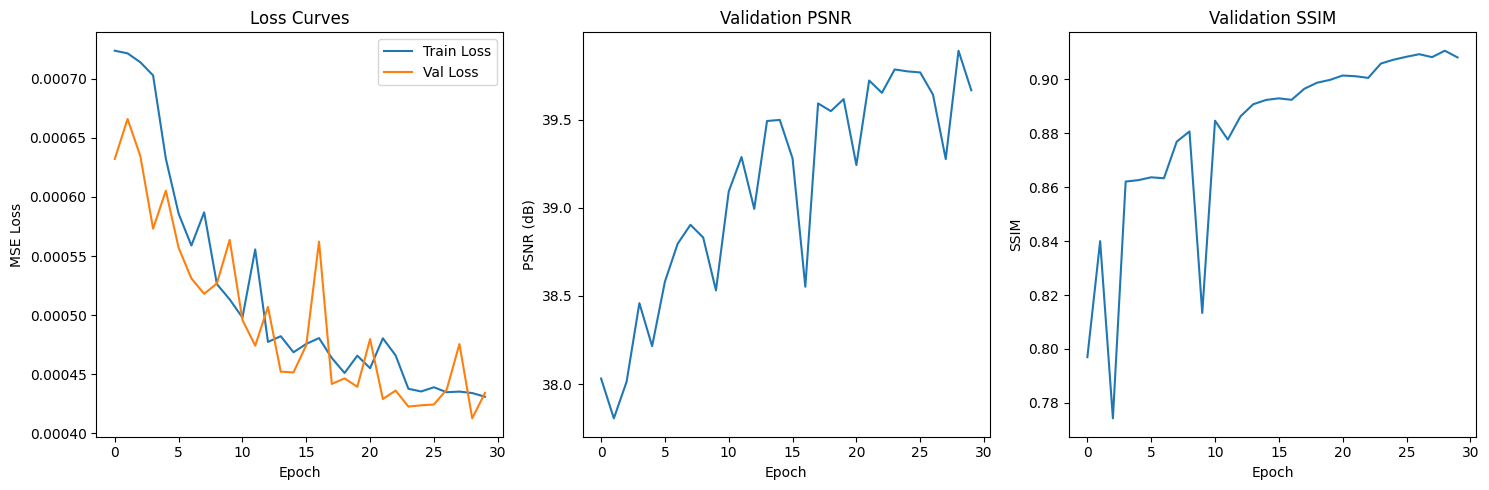

In [13]:
# Plot training and validation metrics
plt.figure(figsize=(15, 5))

# Loss curve
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Loss Curves')

# PSNR curve
plt.subplot(1, 3, 2)
plt.plot(val_psnrs)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')

# SSIM curve
plt.subplot(1, 3, 3)
plt.plot(val_ssims)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')

plt.tight_layout()
plt.show()

## 7. Load Best Model and Final Evaluation

Load the best model from training and evaluate it on the test set.

In [23]:

checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
if os.path.exists(checkpoint_path):
    
    try:
        
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        print("Successfully loaded model with weights_only=False")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
      
        try:
            
            import numpy as np
            from torch.serialization import add_safe_globals
          
            add_safe_globals([np._core.multiarray.scalar])
            
            checkpoint = torch.load(checkpoint_path, weights_only=True)
            print("Successfully loaded model with add_safe_globals")
        except Exception as e2:
            print(f"Failed to load model: {e2}")
            raise
    

    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"  - MSE Loss: {checkpoint['val_loss']:.6f}")
    print(f"  - PSNR: {checkpoint['val_psnr']:.2f} dB")
    print(f"  - SSIM: {checkpoint['val_ssim']:.4f}")
else:
    print("No checkpoint found. Using current model state.")

test_loss, test_psnr, test_ssim = validate(model, test_loader, criterion, device)
print("\nFinal Test Results:")
print(f"  - MSE Loss: {test_loss:.6f}")
print(f"  - PSNR: {test_psnr:.2f} dB")
print(f"  - SSIM: {test_ssim:.4f}")

Successfully loaded model with weights_only=False
Loaded best model from epoch 29 with:
  - MSE Loss: 0.000413
  - PSNR: 39.89 dB
  - SSIM: 0.9106


Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Final Test Results:
  - MSE Loss: 0.000413
  - PSNR: 39.89 dB
  - SSIM: 0.9106


## 8. Visualize Super-Resolution Results

Generate super-resolved images for visual comparison with the ground truth.

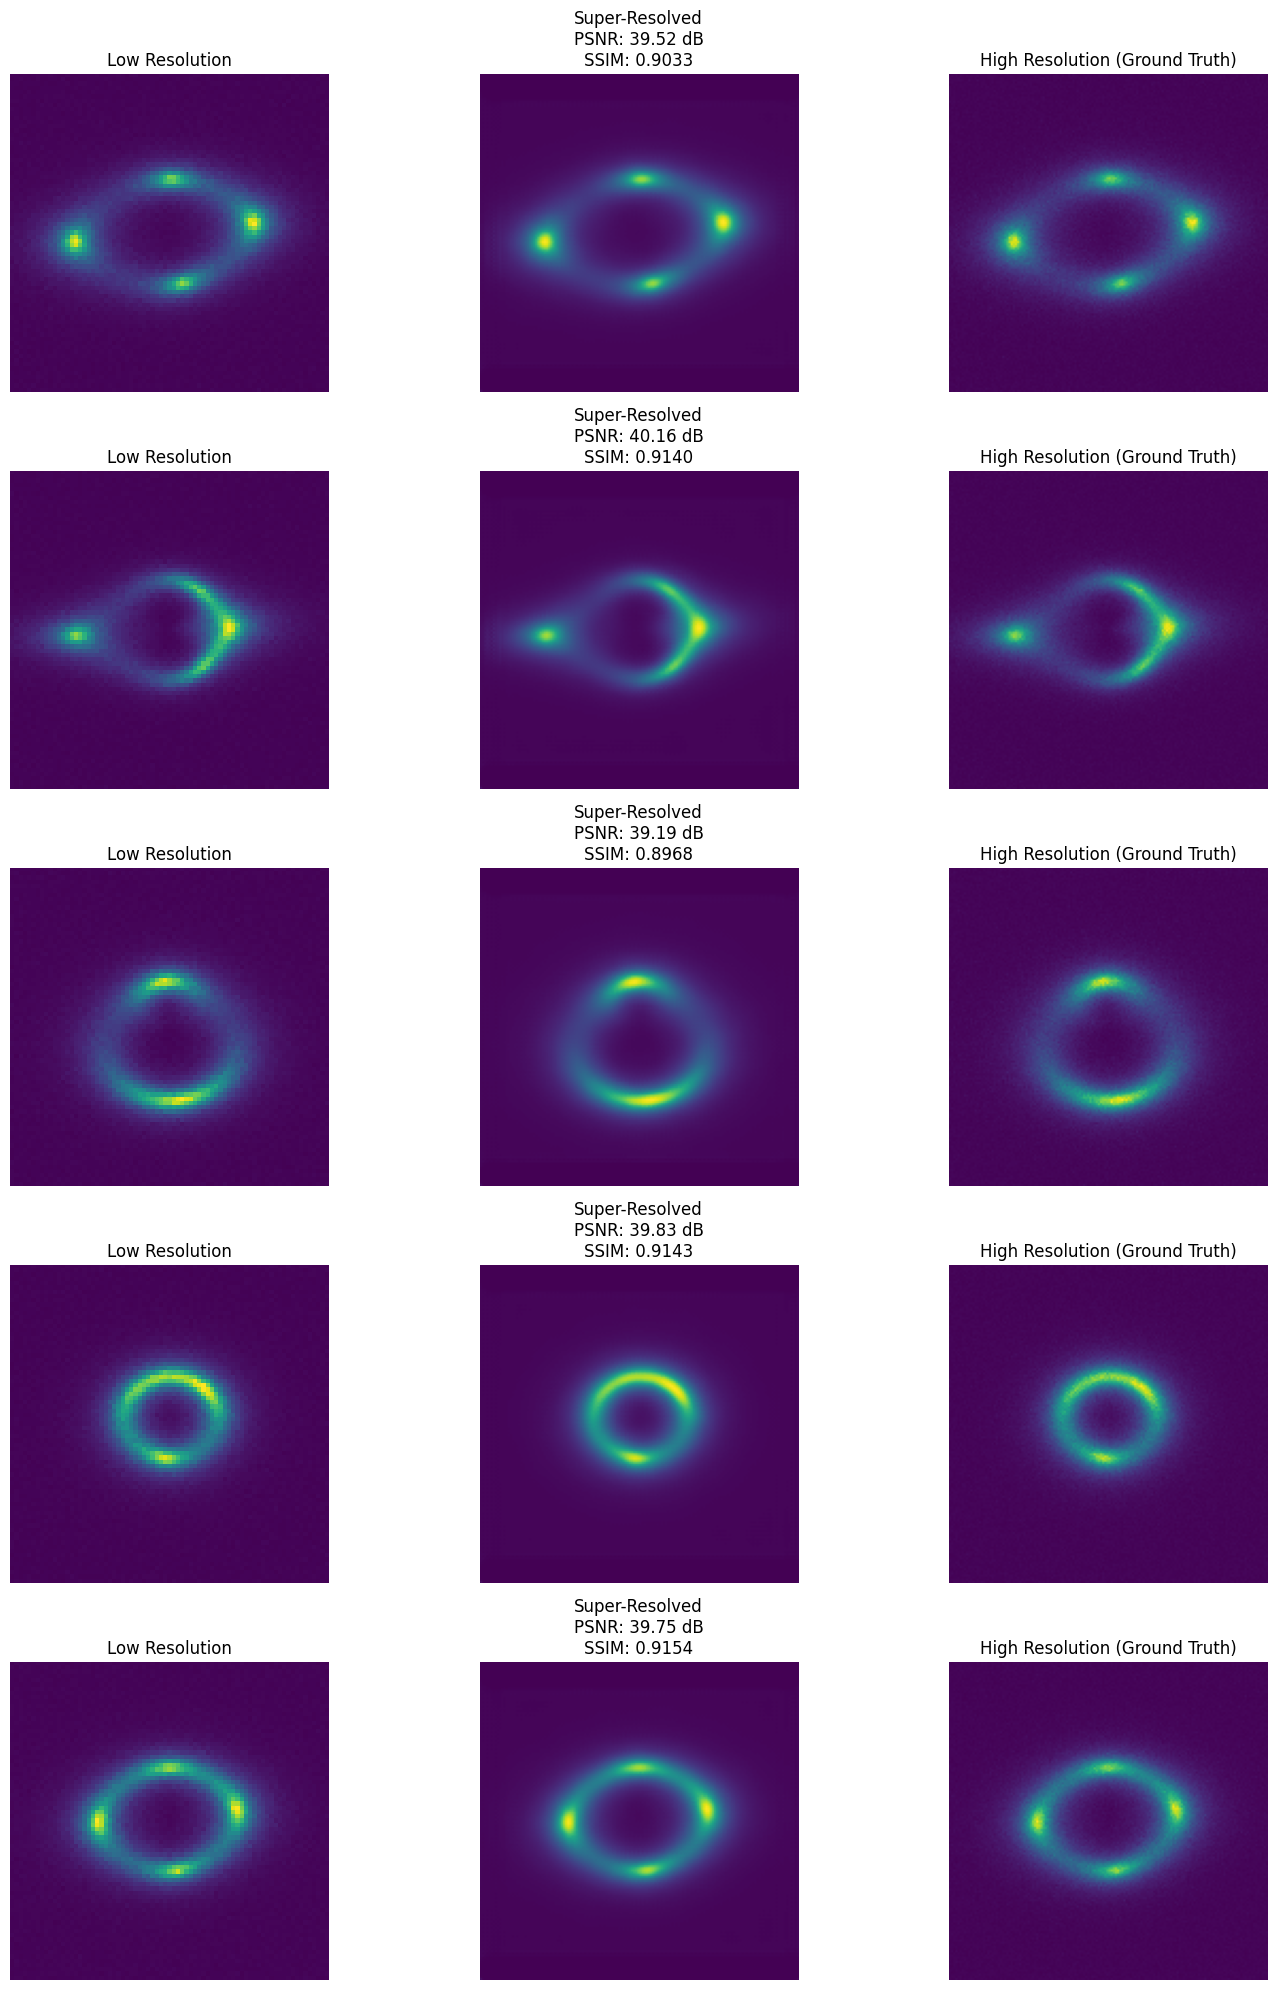

In [24]:
def generate_sr_samples(model, dataloader, device, num_samples=5):
    
    model.eval()
    results = []
    
    with torch.no_grad():
        for lr_imgs, hr_imgs in dataloader:
            
            if len(results) >= num_samples:
                break
   
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
          
            sr_imgs = model(lr_imgs)
         
            for i in range(lr_imgs.size(0)):
                if len(results) >= num_samples:
                    break
                    
                lr_img = lr_imgs[i].cpu().squeeze().numpy() * 0.5 + 0.5
                hr_img = hr_imgs[i].cpu().squeeze().numpy() * 0.5 + 0.5
                sr_img = sr_imgs[i].cpu().squeeze().numpy() * 0.5 + 0.5
                
                # Calculate metrics
                sr_psnr, sr_ssim = calculate_metrics(sr_imgs[i].squeeze(), hr_imgs[i].squeeze())
                
                results.append({
                    'lr': lr_img,
                    'hr': hr_img,
                    'sr': sr_img,
                    'psnr': sr_psnr,
                    'ssim': sr_ssim
                })
    
    return results


results = generate_sr_samples(model, test_loader, device, num_samples=5)

# Plot results
plt.figure(figsize=(15, 4 * len(results)))

for i, result in enumerate(results):
    plt.subplot(len(results), 3, i*3 + 1)
    plt.imshow(result['lr'], cmap='viridis')
    plt.title('Low Resolution')
    plt.axis('off')
    
    plt.subplot(len(results), 3, i*3 + 2)
    plt.imshow(result['sr'], cmap='viridis')
    plt.title(f"Super-Resolved\nPSNR: {result['psnr']:.2f} dB\nSSIM: {result['ssim']:.4f}")
    plt.axis('off')
    
    plt.subplot(len(results), 3, i*3 + 3)
    plt.imshow(result['hr'], cmap='viridis')
    plt.title('High Resolution (Ground Truth)')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 9. Difference Maps Visualization

Create difference maps to highlight where the model performs best and worst.

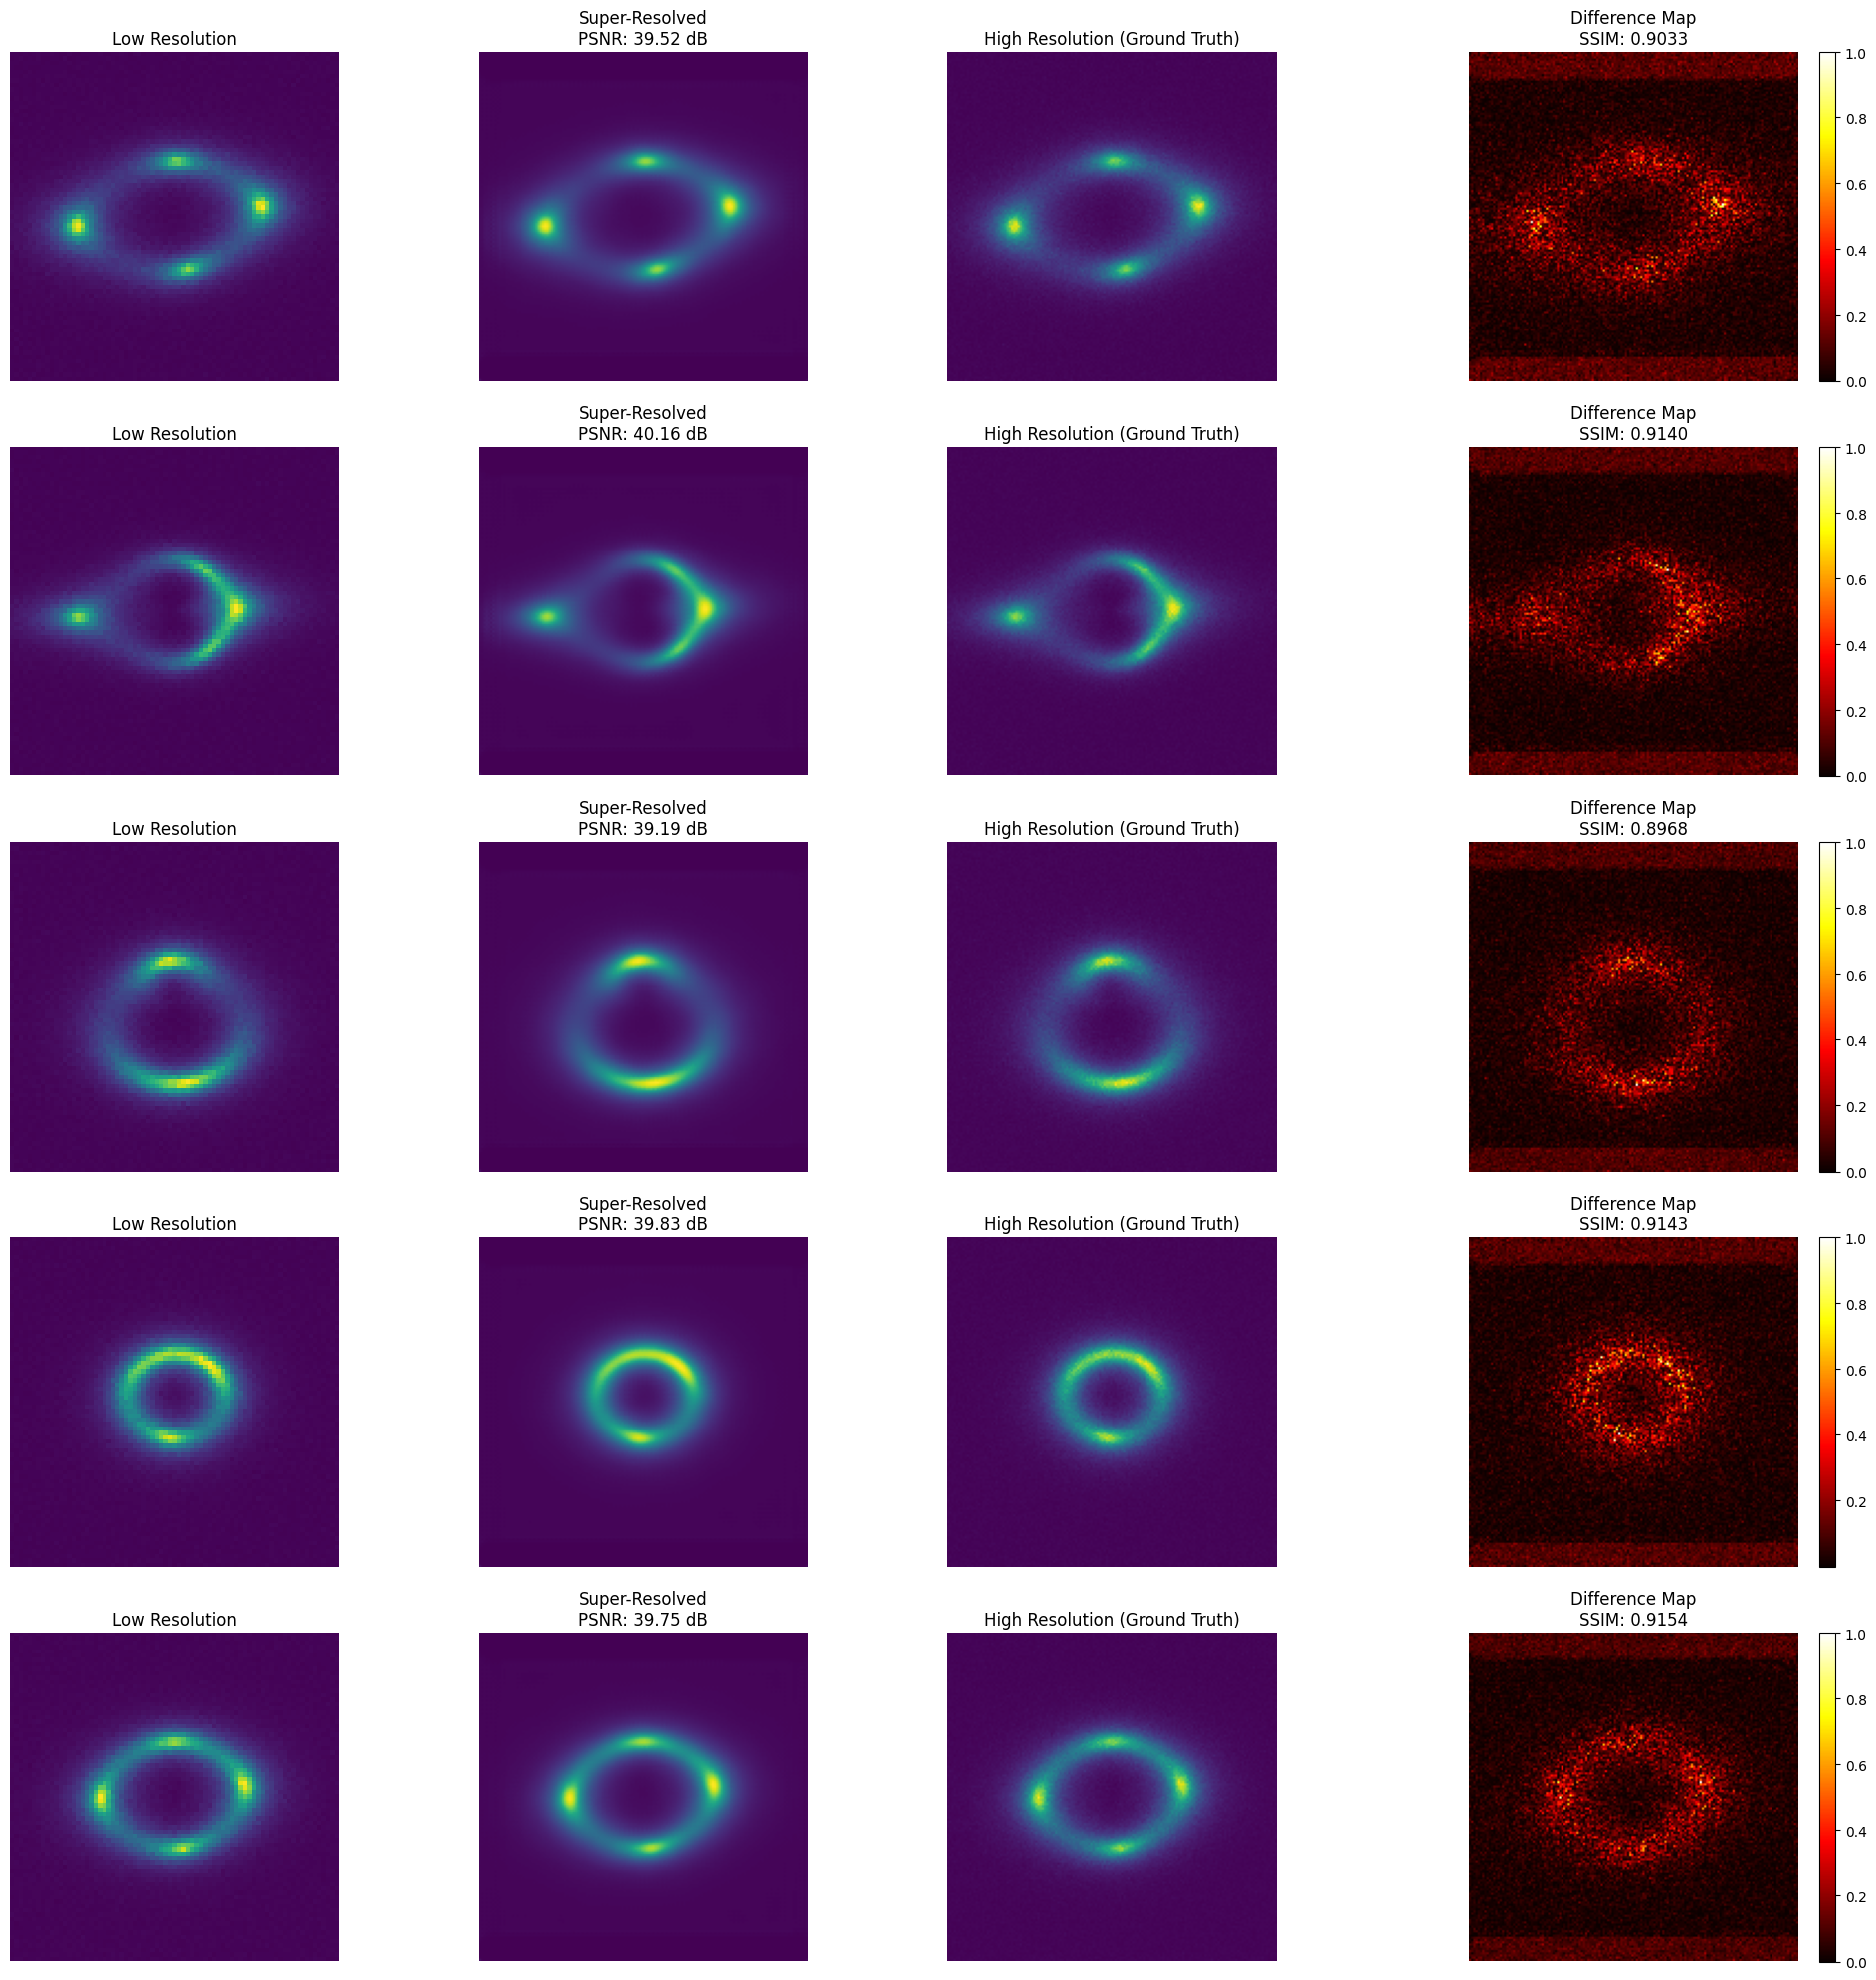

In [25]:

def create_diff_image(img1, img2):
 
    diff = np.abs(img1 - img2)
    
    if diff.max() > 0:
        diff = diff / diff.max()
    return diff

plt.figure(figsize=(20, 4 * len(results)))

for i, result in enumerate(results):

    plt.subplot(len(results), 4, i*4 + 1)
    plt.imshow(result['lr'], cmap='viridis')
    plt.title('Low Resolution')
    plt.axis('off')
    
    plt.subplot(len(results), 4, i*4 + 2)
    plt.imshow(result['sr'], cmap='viridis')
    plt.title(f"Super-Resolved\nPSNR: {result['psnr']:.2f} dB")
    plt.axis('off')
    
    plt.subplot(len(results), 4, i*4 + 3)
    plt.imshow(result['hr'], cmap='viridis')
    plt.title('High Resolution (Ground Truth)')
    plt.axis('off')
    
    # Difference map
    plt.subplot(len(results), 4, i*4 + 4)
    diff = create_diff_image(result['sr'], result['hr'])
    plt.imshow(diff, cmap='hot')
    plt.title(f"Difference Map\nSSIM: {result['ssim']:.4f}")
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()